In [3]:
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from seirsplus_fix.models import *
from tqdm.notebook import tqdm
from scipy.special import softmax

from collections import Counter
from copy import deepcopy

In [4]:
def preprocess_data(data_path):
    """
    data_path -- путь до pickle файла - словаря, где ключ -- дата, значение -- граф networkx
    
    Если id пользователей сбит или не является int, то переводит id к int, начиная с 0
    
    return: dict, где ключ -- дата, значение -- граф networkx
    """
    with open(data_path, 'rb') as f:
        x = pickle.load(f)

    set_of_vertic = set()
    for key in x:
        set_of_vertic |= set(x[key].nodes())

    mapping = {ver: new_ver for new_ver, ver in enumerate(set_of_vertic)}

    x_new = {}
    for day in x:
        x_new[day] = nx.relabel_nodes(x[day], mapping)

    return x_new

In [5]:
def generate_graphs_from_reality_perm(Gs, set_of_vertic, n_perm = 13):
    
    Gs_new = {}
    for day in x:
        G = Gs[day]

        set_of_isolation = set_of_vertic - set(G.nodes())
        G.add_nodes_from(list(set_of_isolation))

        adj_matrix = nx.adjacency_matrix(G, nodelist=sorted(G.nodes()), weight='weight').A
        ADJ = adj_matrix.copy()

        for i in range(n_perm):
            ADJ += nx.adjacency_matrix(G, nodelist=np.random.permutation(sorted(G.nodes())), weight='weight').A

        ADJ = (2 / n_perm * ADJ).astype(int)
        
        ADJ = np.where(ADJ > 23 * 60 * 60, 23 * 60 * 60, ADJ)

        G_new = nx.from_numpy_array(ADJ, create_using=nx.Graph)

        Gs_new[day] = G_new
        
    return Gs_new

In [6]:
def generate_graphs_from_reality_spawn(Gs, set_of_vertic, n_spawn = 13):
    
    Gs_new = {}
    for day in x:
        G = Gs[day]

        set_of_isolation = set_of_vertic - set(G.nodes())
        G.add_nodes_from(list(set_of_isolation))

        adj_matrix = nx.adjacency_matrix(G, nodelist = sorted(G.nodes()), weight='weight').A
        ADJ = adj_matrix.copy()

        for i in range(n_spawn):
            G_curr = Gs[np.random.choice(list(Gs.keys()))]
            set_of_isolation = set_of_vertic - set(G_curr.nodes())
            G_curr.add_nodes_from(list(set_of_isolation))
            
            ADJ += nx.adjacency_matrix(G_curr, nodelist = sorted(G_curr.nodes()), weight='weight').A

        ADJ = (2 / n_spawn * ADJ).astype(int)
        
        ADJ = np.where(ADJ > 23 * 60 * 60, 23 * 60 * 60, ADJ)

        G_new = nx.from_numpy_array(ADJ, create_using=nx.Graph)

        Gs_new[day] = G_new
        
    return Gs_new

1. Создаем граф с весами:
    1. Генерируем граф заданной размерности и плотности
    2. Для каждого ребра выбираем случайно его временную группу
    3. Для каждого ребра генерируем время из этой временной группы
2. В цикле по дням и по ребрам:
    1. Оставляем его в той же временной группе (0.42)
    2. Сдвигаем его на одну группу (равновероятно вниз и вверх) (0.45) (если сдвигаем вверх самый большой, то ничего не меняем в группе, аналогично для смещение вниз самого маленького)
    3. Сдвигаем на две группы (0.05) (для средней группы оставляем как есть)
    4. Удаляем (0.08)

In [39]:
def generate_sinthentic_contacts_graphs(G = None, weight_gen = False, N = 10, n = 300, s = 3, v = 2, p_in = 0.06, p_out = 0.035, seed = 1369,
                                        group_border = [[15,1800],[3600, 21600],[25200, 39600]],
                                        group_probs = [0.55, 0.35, 0.1], moves_probs = [0.42, 0.45, 0.05, 0.08],
                                        adding_probs = [8/15, 4/15, 2/15, 1/15]):
    """
        n (int) – Number of nodes in the graph
        s (float) – Mean cluster size
        v (float) – Shape parameter. The variance of cluster size distribution is s/v.
        p_in (float) – Probabilty of intra cluster connection.
        p_out (float) – Probability of inter cluster connection.
        seed (integer, random_state, or None (default)) – Indicator of random number generation state.
    """
    
    def get_time(zone, group_border = group_border):
        if   's' == zone:
            return np.random.randint(group_border[0][0], group_border[0][1]) # до 30 минут
        elif 'm' == zone:
            return np.random.randint(group_border[1][0], group_border[1][1]) # от часа, до шести
        elif 'b' == zone:
            return np.random.randint(group_border[2][0], group_border[2][1]) # от 7 до 12 часов
        
    def get_old_zone(G, u, v, group_border = group_border):
        w = G.get_edge_data(u, v)['weight']
        if w < group_border[0][1]:
            return 's'
        elif w > group_border[2][0]:
            return 'b'
        else:
            return 'm'
    
    if not G:
        G = nx.Graph(nx.gaussian_random_partition_graph(n, s, v, p_in, p_out, \
                                                            directed = False, seed = seed), weight = True)

        for (u, v) in G.edges():
            zone = np.random.choice(['s','m','b'], p = group_probs)
            G.edges[u,v]['weight'] = get_time(zone)
    
    if G and weight_gen:
        for (u, v) in G.edges():
            zone = np.random.choice(['s','m','b'], p = group_probs)
            G.edges[u,v]['weight'] = get_time(zone)        
            
    
    Gs = {}
    for day in range(N):
        G_curr = deepcopy(G)
        for (u, v) in G.edges():
            old_zone = get_old_zone(G, u, v)
            move = np.random.choice([0, 1, 2, -1], p = moves_probs)
            if move == 0:
                G.edges[u,v]['weight'] = get_time(old_zone)
            elif move == 1:
                if np.random.choice([0, 1], p = [0.5, 0.5]): # up
                    if old_zone == 'm':
                        G_curr.edges[u,v]['weight'] = get_time('b')
                    elif old_zone == 's':
                        G_curr.edges[u,v]['weight'] = get_time('m')
                    elif old_zone == 'b':
                        G_curr.edges[u,v]['weight'] = get_time('b')
                else: # down
                    if old_zone == 'm':
                        G_curr.edges[u,v]['weight'] = get_time('s')
                    elif old_zone == 's':
                        G_curr.edges[u,v]['weight'] = get_time('s')
                    elif old_zone == 'b':
                        G_curr.edges[u,v]['weight'] = get_time('m')
            elif move == 2:
                if old_zone == 'm':
                    G_curr.edges[u,v]['weight'] = get_time(old_zone)
                elif old_zone == 's':
                    G_curr.edges[u,v]['weight'] = get_time('b')
                elif old_zone == 'b':
                    G_curr.edges[u,v]['weight'] = get_time('s')
            else:
                G_curr.remove_edge(u, v)
        # Если нужно, то можно быстро преобразовать это для любого числа соседей
        for ver in G_curr.nodes():
            adding = np.random.choice([0, 1, 2, 3], p = adding_probs)

            potential_neighbor = (set(G_curr.nodes()) - {ver}) - set(nx.node_boundary(G_curr, [ver]))
            neighbors = random.sample(potential_neighbor, adding)
            for neigh in neighbors:
                zone = np.random.choice(['s','m','b'], p = group_probs)
                G_curr.add_edge(ver,neigh, weight=get_time(zone))
                
        Gs[day] = G_curr
        
    return Gs

---

In [35]:
x = preprocess_data('graph_dict_processed.p')

# Находим все возможные id вершин
set_of_vertic = set()
for key in x:
    set_of_vertic |= set(x[key].nodes())

In [40]:
GPM = generate_graphs_from_reality_perm(x, set_of_vertic, n_perm = 13)
GSN = generate_graphs_from_reality_spawn(x, set_of_vertic, n_spawn = 13)
GSC = generate_sinthentic_contacts_graphs(N = 53, n = 100)

In [54]:
with open('generated_graphs/GPM_p13.p', 'wb') as fp:
    pickle.dump(GPM, fp)
    
with open('generated_graphs/GSN_s13.p', 'wb') as fp:
    pickle.dump(GSN, fp)
    
with open('generated_graphs/GSC_n100_v2.p', 'wb') as fp:
    pickle.dump(GSC, fp)

In [56]:
def plot_spread_epidemic_on_graph(Gs, path_to_save, gif_name, image_size = 15, node_size = 3000, font_size = 35,
                                  make_gif = False):
    """
    data              -- данные, полученные из функции sampling_epidemic
    Gs                -- словарь с графами
    path_to_save      -- место, где будут сохранены отрисованные графы
    image_size        -- размер изображения
    node_size         -- размер вершин на изображении
    font_size         -- размер текста в вершинах
    make_gif          -- сделать ли gif
    
    return: None
    """
    import os
    
    if not os.path.exists(path_to_save):
        raise FileNotFoundError(f"Указанная папка для сохранения результатов {path_to_save} не существует")
    
    set_of_vertic = set()
    for key in Gs:
        set_of_vertic |= set(Gs[key].nodes())

    for ind, key in enumerate(Gs):

        G = Gs[key]
        set_of_isolation = set_of_vertic - set(G.nodes())
        G.add_nodes_from(list(set_of_isolation))
        
        if ind == 0:
            pos = nx.spring_layout(G, iterations=1)
                
        plt.figure(figsize=(image_size,image_size))

        nx.draw(G, pos, with_labels=True, node_size=node_size, font_size=font_size)

        plt.savefig(f'{path_to_save}/{key}.png', bbox_inches='tight')
        
    if make_gif:
        import glob
        from PIL import Image

        fp_in = path_to_save + "/*.png"
        fp_out = path_to_save + f'/{gif_name}.gif'

        img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=800, loop=0)

In [1]:
plot_spread_epidemic_on_graph(GSN, 'Сток', 'GSN_s13', make_gif = True)

In [ ]:
plot_spread_epidemic_on_graph(GPM, 'Сток', 'GPM_p13', make_gif = True)

In [2]:
plot_spread_epidemic_on_graph(GSC, 'Сток', 'GSC_n100', make_gif = True)

---

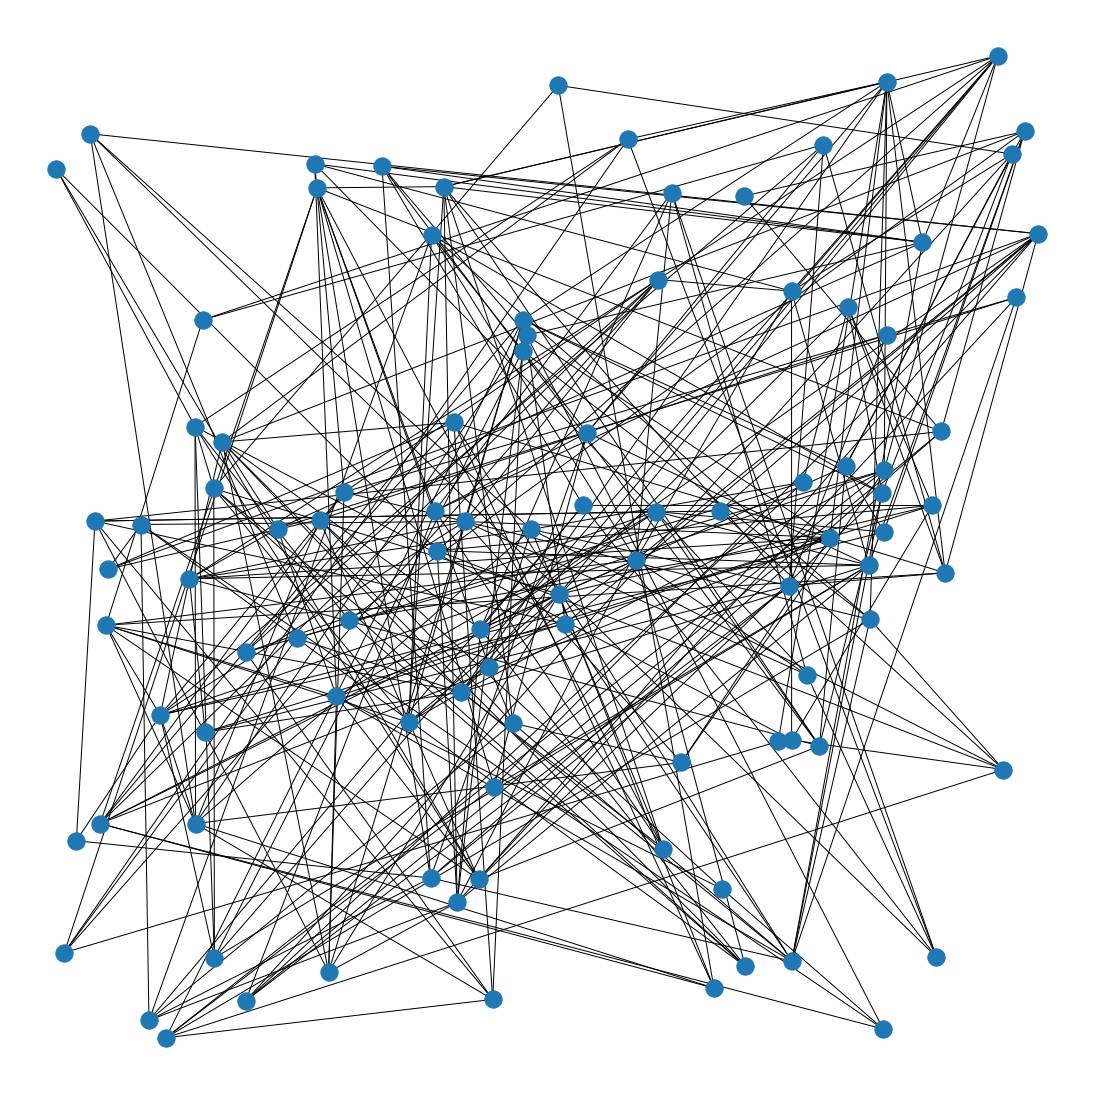

In [15]:
G = nx.Graph(nx.gaussian_random_partition_graph(100, 3, 2, 0.06, 0.035, \
                                                            directed = False, seed = 1369), weight = True)
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G, iterations=1)
nx.draw(G, pos)